from param_analysis import ParameterAnalysis
from plots import *

In [1]:
from param_analysis import ParameterAnalysis
from plots import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ecb_precision_gammas = [4,5,6,7,8]
#ecb_precision_gammas = [7]
connectedness_values = [0.4,0.8]

#num_agent_values = [3,5,8]
#num_agent_values = [5]
num_agent_values = [12]

n = len(num_agent_values)
c = len(connectedness_values)
env_precision_gammas = [9]
#b_precision_gammas = [7]
b_precision_gammas = [3,4,5,6,7,8]
lr = [0.001,0.1,0.3,0.5,0.7,0.9,1.2]

#variances = [0.01, 0.1, 0.5, 0.8, 1.1, 1.5, 2]
variances = [0.1]
r_len = len(ecb_precision_gammas)
e_len = len(env_precision_gammas)
b_len = len(b_precision_gammas)
v_len = len(variances)
lr_len = len(lr)
n_trials = 40
    

In [4]:
import itertools
param_combos = itertools.product(num_agent_values, connectedness_values, ecb_precision_gammas,env_precision_gammas,b_precision_gammas, variances, lr)
# %% construct network
length = len(list(param_combos))
print("number of combinations: " +str(length))

number of combinations: 420


In [5]:
params = ParameterAnalysis('','', num_agent_values, connectedness_values, ecb_precision_gammas, env_precision_gammas, b_precision_gammas, lr, variances, n_trials)

In [ ]:
params.n_trials

40

In [ ]:
data = params.load_results("results/lr_b_e_results_structure")

(420, 40, 4)


Initial Large Sweep over Parameter Space - Analyzing the clustering metrics 

In [ ]:
params.get_overall_metrics(from_files = True)

IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [ ]:
params.cluster_kls

In [9]:
all_parameters = np.array(list(params.get_param_combinations()))

In [ ]:
params.n_d.value = num_agent_values[0]
params.env_d.value = env_precision_gammas[0]
params.b_d.value = b_precision_gammas[0]
params.c_d.value = connectedness_values[-1]
params.ecb_d.value = ecb_precision_gammas[0]
params.update_params(all_parameters[0])
params.get_sim_results_from_files()
print("done")

In [11]:

def get_indices_by_criteria(params):
    criteria_indices = {}
    consensus_indices = np.where(np.isnan(params.insider_outsider_ratios[:,-1]))[0]
    consensus_ratios = params.insider_outsider_ratios[consensus_indices]
    consensus_params = all_parameters[consensus_indices]
    criteria_indices["consensus"] = [consensus_indices, consensus_ratios, consensus_params]
    clustering_indices = np.where(~np.isnan(params.insider_outsider_ratios[:,-1]))[0]
    clustering_params = all_parameters[clustering_indices]
    clustering_ratios = params.insider_outsider_ratios[clustering_indices]
    criteria_indices["clustering"] = [clustering_indices, clustering_ratios, clustering_params]

    return criteria_indices


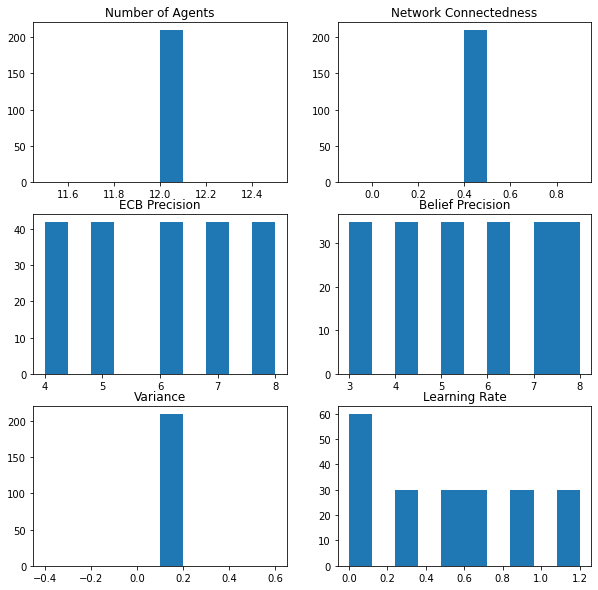

In [12]:
criteria_indices = get_indices_by_criteria(params)

plot_param_histograms(criteria_indices["clustering"][-1])


# HERE WE SHOW CONNECTEDNESS AND ECB ON CONSENSUS AND CLUSTERING FOR THE FIRST TIME 

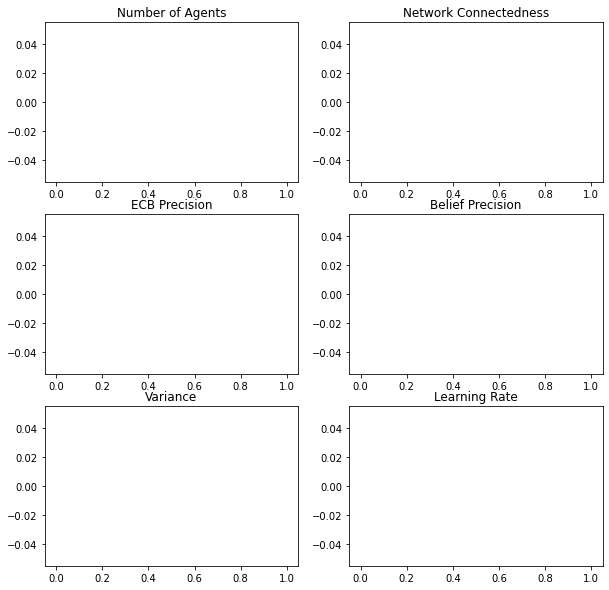

In [13]:
plot_param_histograms(criteria_indices["consensus"][-1])

Bifurcation Plots - Belief Extremity per ECB Precision

In [39]:

def plot_bifurcations(all_parameters, b_precision_gammas, lr, metric, metric_name):
    fig, axs = plt.subplots(2, 1, figsize=(12,8))
    belief_extremities1 = isolate_metric_by(all_parameters,metric, b_precision_gammas, 3)
    belief_extremities2 = isolate_metric_by(all_parameters,metric, lr, -1)
    axs[0].plot(b_precision_gammas, belief_extremities1)
    axs[0].set_xlabel("ECB Precision Gammas")
    axs[0].set_ylabel(metric_name)

    axs[1].plot(lr, belief_extremities2)
    axs[1].set_xlabel("Learning Rate")
    axs[1].set_ylabel(metric_name)



In [15]:
b_precision_gammas

[3, 4, 5, 6, 7, 8]

In [16]:
def isolate_metric_by(all_parameters, metric, parameter, idx):
    metric_list = []
    for i, e in enumerate(parameter):
        indices = np.where(all_parameters[:,idx] == e)[0]
        _params = all_parameters[indices]
        metrics = np.nanmean(metric[indices])
        metric_list.append(metrics)
    return metric_list

In [17]:
belief_extremities1 = isolate_metric_by(all_parameters,params.insider_outsider_ratios, b_precision_gammas, 3)


In [18]:
belief_extremities1

[0.22486856314346398,
 0.21707744155756573,
 0.17537697618045986,
 0.13329693665938422,
 0.1094629973379559,
 0.09814587623180053]

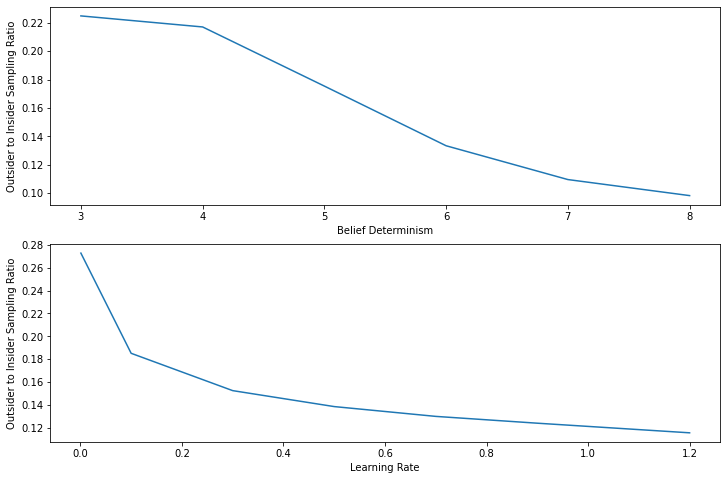

In [19]:
plot_bifurcations(criteria_indices["clustering"][-1],b_precision_gammas,lr, params.insider_outsider_ratios, "Outsider to Insider Sampling Ratio")


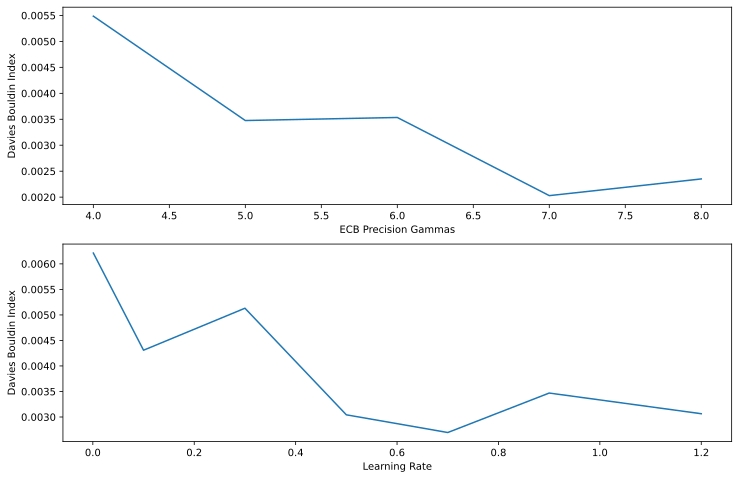

In [41]:
plot_bifurcations(criteria_indices["clustering"][-1],ecb_precision_gammas,lr, params.db_indices, "Davies Bouldin Index")


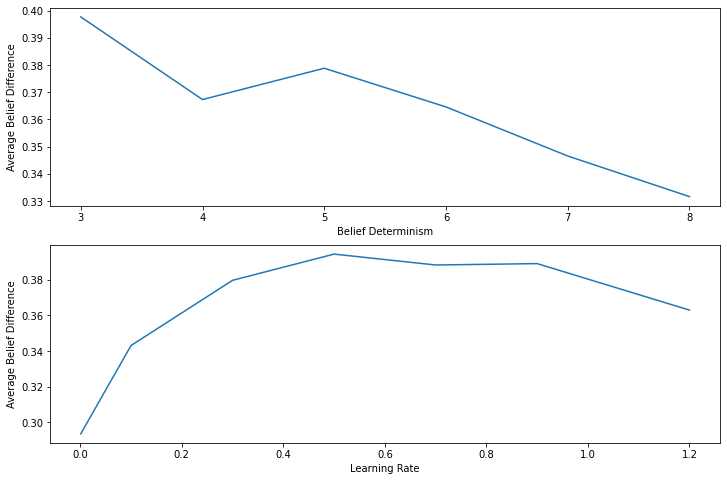

In [21]:
plot_bifurcations(criteria_indices["clustering"][-1],b_precision_gammas,lr, params.avg_belief_diff, "Average Belief Difference")


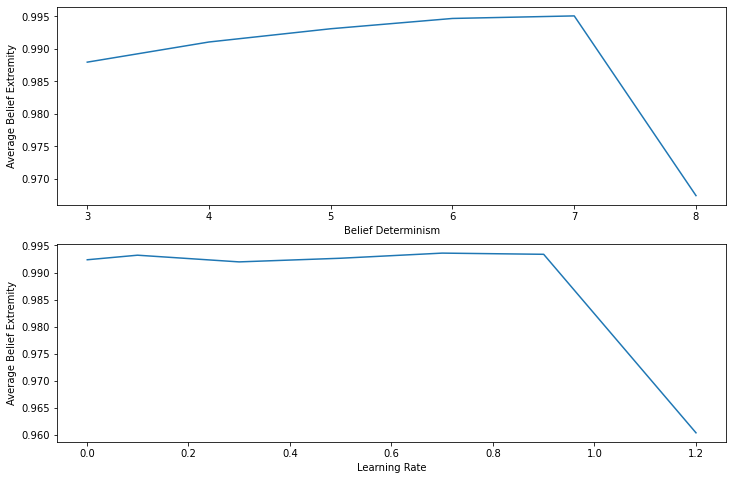

In [22]:
plot_bifurcations(criteria_indices["clustering"][-1],b_precision_gammas,lr, params.avg_belief_extremity, "Average Belief Extremity")


Agents sammple outsiders much less with a higher learning rate - which makes sense

([<matplotlib.axis.YTick at 0x7fbab8ecb670>,
 [Text(0, 0, '3'),
  Text(0, 1, '4'),
  Text(0, 2, '5'),
  Text(0, 3, '6'),
  Text(0, 4, '7'),
  Text(0, 5, '8')])

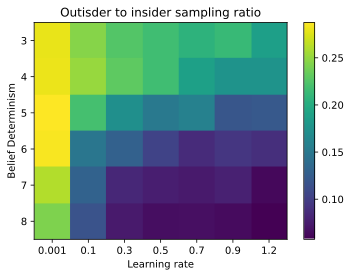

In [29]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure()
ecb_lr = get_2d_histogram(b_precision_gammas, lr, all_parameters, params.insider_outsider_ratios, 3, -1)
plt.imshow(ecb_lr)
plt.colorbar()
plt.xlabel("Learning rate")
plt.ylabel("Belief Determinism")
plt.title("Outisder to insider sampling ratio")
plt.xticks(np.arange(0,len(lr),1), labels = lr)
plt.yticks(np.arange(0,len(b_precision_gammas),1), labels =b_precision_gammas)


([<matplotlib.axis.YTick at 0x7fbab8cb3ee0>,
 [Text(0, 0, '4'),
  Text(0, 1, '5'),
  Text(0, 2, '6'),
  Text(0, 3, '7'),
  Text(0, 4, '8')])

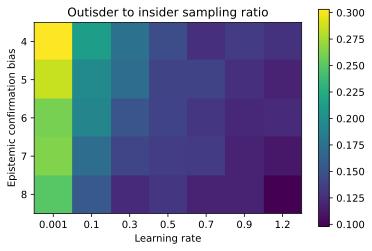

In [32]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure()
ecb_lr = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, params.insider_outsider_ratios, 2, -1)
plt.imshow(ecb_lr)
plt.colorbar()
plt.xlabel("Learning rate")
plt.ylabel("Epistemic confirmation bias")
plt.title("Outisder to insider sampling ratio")
plt.xticks(np.arange(0,len(lr),1), labels = lr)
plt.yticks(np.arange(0,len(ecb_precision_gammas),1), labels =ecb_precision_gammas)


([<matplotlib.axis.YTick at 0x7fbab7005760>,
 [Text(0, 0, '4'),
  Text(0, 1, '5'),
  Text(0, 2, '6'),
  Text(0, 3, '7'),
  Text(0, 4, '8')])

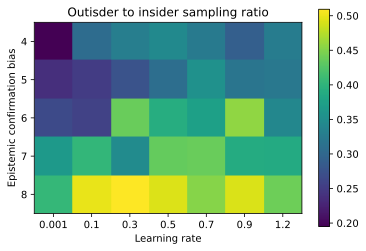

In [37]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure()
ecb_lr = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, params.avg_belief_diff, 2, -1)
plt.imshow(ecb_lr)
plt.colorbar()
plt.xlabel("Learning rate")
plt.ylabel("Epistemic confirmation bias")
plt.title("Outisder to insider sampling ratio")
plt.xticks(np.arange(0,len(lr),1), labels = lr)
plt.yticks(np.arange(0,len(ecb_precision_gammas),1), labels =ecb_precision_gammas)


In [15]:
 params.avg_belief_extremity

array([0.96627231, 0.99359246, 0.996585  , 0.99752046, 0.99812207,
       0.99805054, 0.99851058, 0.99863352, 0.99880478, 0.99483766,
       0.99836514, 0.99779071, 0.99506815, 0.97448643, 0.99457072,
       0.99121514, 0.9961554 , 0.99803736, 0.99652792, 0.99647734,
       0.99801585, 0.99894063, 0.99912359, 0.99424456, 0.99505319,
       0.99488641, 0.9751259 , 0.99465464, 0.9967397 , 0.99310608,
       0.9981424 , 0.99793167, 0.99853004, 0.99865191, 0.99900172,
       0.99913417, 0.99922338, 0.99387245, 0.99328782, 0.96940651,
       0.99463143, 0.99714326, 0.99777854, 0.99815033, 0.99836724,
       0.99599719, 0.9986514 , 0.99899255, 0.9972812 , 0.99830435,
       0.99736043, 0.99502625, 0.97848922, 0.99519971, 0.99709312,
       0.99782963, 0.99814357, 0.99836725, 0.99853837, 0.99865518,
       0.99358597, 0.99914995, 0.99667289, 0.99815904, 0.99606244,
       0.98078586, 0.99505143, 0.99717425, 0.99781407, 0.99814766,
       0.99837338, 0.9985319 , 0.99866184, 0.99900556, 0.99915

In [18]:
params.connectedness_values

[0.2, 0.5, 0.8]

In [16]:
def plot_heatmaps(metric, ecb_precision_gammas, b_precision_gammas, learning_rates, variance,all_parameters):
    fig, axs = plt.subplots(3, 3, figsize=(12,8))
    ecb_lr = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, metric, 2, -1)
    plot_2d_histogram(axs[0,0], ecb_lr, "Learning Rate", "ECB Precisions", ecb_precision_gammas, lr)

    ecb_b = get_2d_histogram(ecb_precision_gammas, b_precision_gammas, all_parameters, metric, 2, 3)
    plot_2d_histogram(axs[0,1], ecb_b, "Belief Determinism", "ECB Precisions", ecb_precision_gammas, b_precision_gammas)

    ecb_v = get_2d_histogram(ecb_precision_gammas, variance, all_parameters, metric, 2, -2)
    plot_2d_histogram(axs[1,0], ecb_v, "Variance", "ECB Precision", ecb_precision_gammas, variance)

    ecb_c = get_2d_histogram(ecb_precision_gammas, connectedness_values, all_parameters, metric, 2, 1)
    plot_2d_histogram(axs[1,1], ecb_c, "Network Connectivity", "ECB Precision", ecb_precision_gammas, connectedness_values)

    ecb_c = get_2d_histogram(lr, b_precision_gammas, all_parameters, metric, -1,3 )
    plot_2d_histogram(axs[1,1], ecb_c, "Network Connectivity", "ECB Precision", ecb_precision_gammas, connectedness_values)



/Users/daphnedemekas/Desktop/Imperial/Thesis/active_inference_opinion_dynamics/Analysis/plots.py:221: RuntimeWarning: Mean of empty slice
  avg_metric = np.nanmean(p2_metrics[np.isfinite(p2_metrics)])


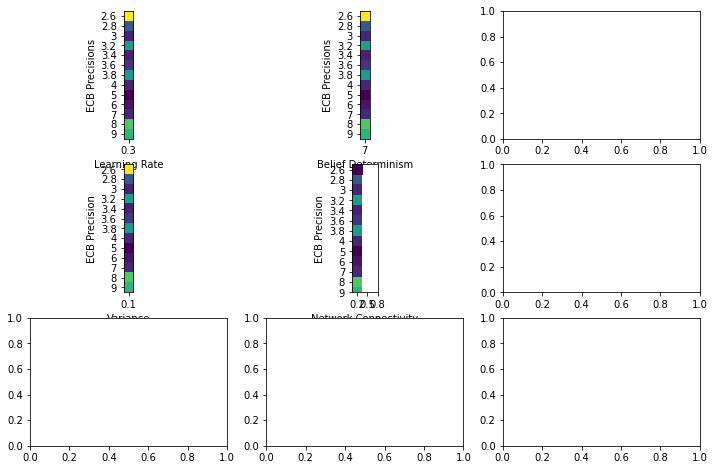

In [17]:
plot_heatmaps(params.insider_outsider_ratios, ecb_precision_gammas, b_precision_gammas, lr, variances,all_parameters)

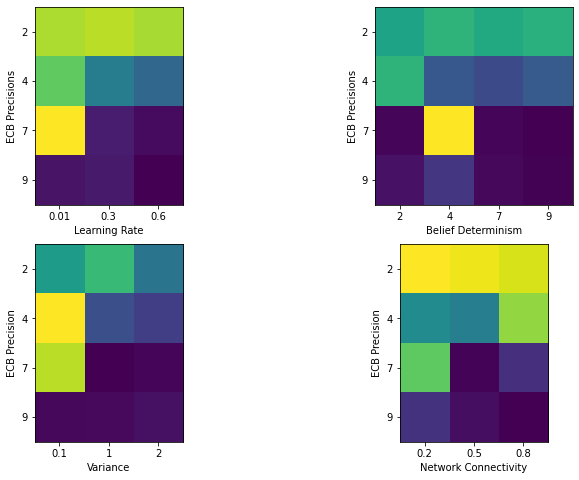

In [118]:
plot_heatmaps(params.db_indices, ecb_precision_gammas, b_precision_gammas, lr, variances,all_parameters)

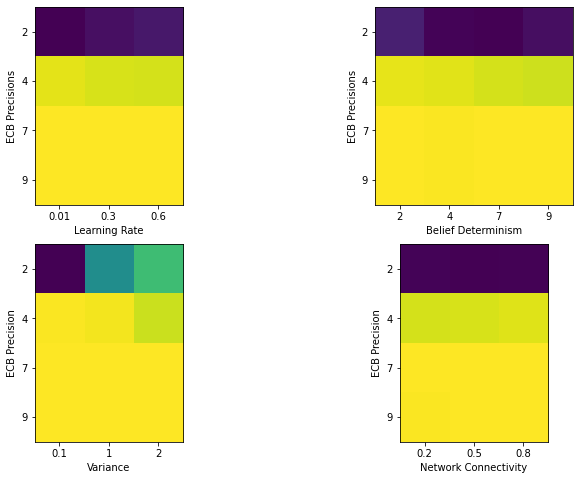

In [119]:
plot_heatmaps(params.avg_belief_extremity, ecb_precision_gammas, b_precision_gammas, lr, variances,all_parameters)

HeatMaps

In [115]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, params.db_indices, 2, -1)
plot_2d_histogram(ecb_b_db_clustering_hist, "Learning Rate", "ECB Precisions", ecb_precision_gammas, lr)
plt.title("Histogram for Outsider to Insider Sampling Ratio ")

TypeError: plot_2d_histogram() missing 1 required positional argument: 'param2'

Text(0.5, 1.0, 'Histogram for Outsider to Insider Sampling Ratio ')

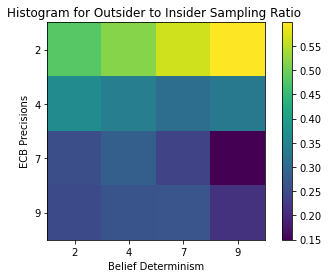

In [90]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, b_precision_gammas, all_parameters, params.insider_outsider_ratios, 2, 3)
plot_2d_histogram(ecb_b_db_clustering_hist, "Belief Determinism", "ECB Precisions", ecb_precision_gammas, b_precision_gammas)
plt.title("Histogram for Outsider to Insider Sampling Ratio ")

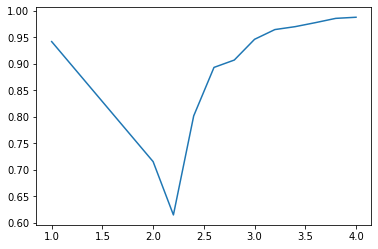

In [300]:
plt.plot(ecb_precision_gammas, belief_extremities)

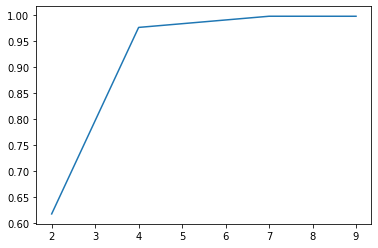

In [267]:
plt.plot(ecb_precision_gammas, belief_extremities)

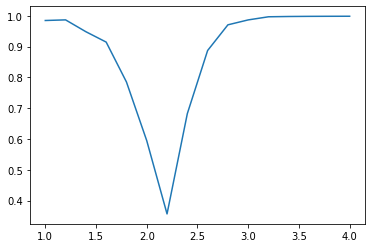

In [251]:
plt.plot(ecb_precision_gammas, belief_extremities)

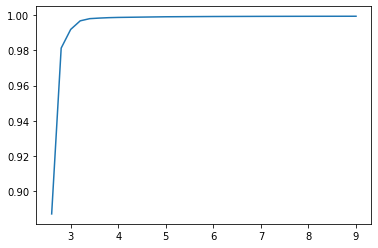

In [236]:
plt.plot(ecb_precision_gammas, belief_extremities)

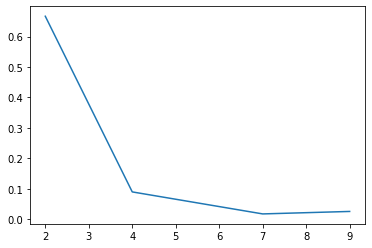

In [268]:
plt.plot(ecb_precision_gammas, belief_diffs)

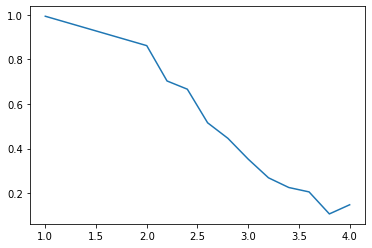

In [301]:
plt.plot(ecb_precision_gammas, belief_diffs)

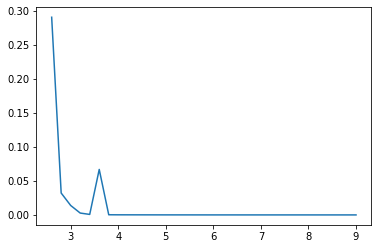

In [237]:
plt.plot(ecb_precision_gammas, belief_diffs)

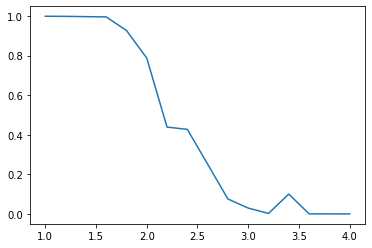

In [252]:
plt.plot(ecb_precision_gammas, belief_diffs)

Text(0.5, 1.0, 'Histogram for Belief Extremity ')

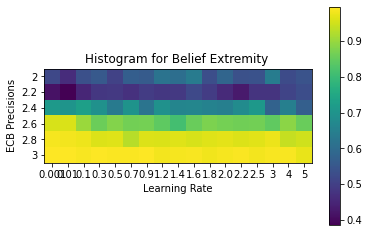

In [63]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, avg_belief_extremity, 2, -1)
plot_2d_histogram(ecb_b_db_clustering_hist, "Learning Rate", "ECB Precisions", ecb_precision_gammas, lr)
plt.title("Histogram for Belief Extremity ")

Text(0.5, 1.0, 'Histogram for Belief Difference ')

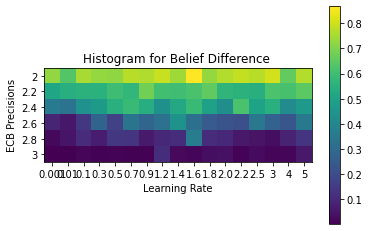

In [64]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, avg_belief_diff, 2, -1)
plot_2d_histogram(ecb_b_db_clustering_hist, "Learning Rate", "ECB Precisions", ecb_precision_gammas, lr)
plt.title("Histogram for Belief Difference ")

/Users/daphnedemekas/Desktop/Imperial/Thesis/active_inference_opinion_dynamics/Analysis/plots.py:144: RuntimeWarning: Mean of empty slice
  avg_metric = np.nanmean(p2_metrics[np.isfinite(p2_metrics)])


Text(0.5, 1.0, 'Histogram for Outsider to Insider Sampling Ratio ')

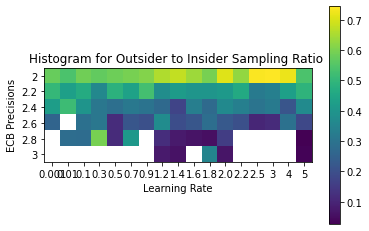

In [65]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, all_parameters, params.insider_outsider_ratios, 2, -1)
plot_2d_histogram(ecb_b_db_clustering_hist, "Learning Rate", "ECB Precisions", ecb_precision_gammas, lr)
plt.title("Histogram for Outsider to Insider Sampling Ratio ")

[[0.99848652 0.998685   0.96547862 0.93562544 0.91702337 0.90475721
  0.87273809]
 [0.66938765 0.55581966 0.57386324 0.72094816 0.77827614 0.81459687
  0.89654965]
 [0.21739265 0.24511901 0.5996746  0.74110198 0.7589304  0.89172863
  0.85253773]
 [0.86869629 0.82978515 0.65975101 0.71343511 0.80393041 0.87595634
  0.86125467]
 [0.98217562 0.97719367 0.83998921 0.82705049 0.82800772 0.88103327
  0.9167787 ]
 [0.99500312 0.99425337 0.92481935 0.84315377 0.85327432 0.82816284
  0.91057218]
 [0.99716868 0.99707299 0.96075735 0.94017955 0.90217599 0.91711712
  0.9085306 ]
 [0.99779241 0.99779483 0.99395118 0.97638419 0.95108127 0.90384115
  0.93040578]
 [0.99813644 0.99810397 0.98922859 0.98331505 0.95167118 0.96232929
  0.9070289 ]
 [0.99836176 0.99835545 0.99457016 0.99466613 0.97481578 0.94917605
  0.93285112]
 [0.99852419 0.998511   0.99839625 0.9963498  0.99020748 0.95092479
  0.96618186]
 [0.99864704 0.99864398 0.99855217 0.99084955 0.99272806 0.96126527
  0.97323465]]


Text(0.5, 1.0, 'Histogram for Belief Extremity ')

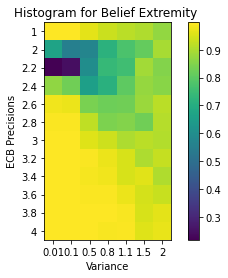

In [302]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, variances, all_parameters, avg_belief_extremity, 2, -2)
plot_2d_histogram(ecb_b_db_clustering_hist, "Variance", "ECB Precisions", ecb_precision_gammas, variances)
plt.title("Histogram for Belief Extremity ")

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
/Users/daphnedemekas/Desktop/Imperial/Thesis/active_inference_opinion_dynamics/Analysis/plots.py:144: RuntimeWarning: Mean of empty slice
  belief_extremities1 = isolate_metric_by(all_parameters,metric, ecb_precisions, 2)


Text(0.5, 1.0, 'Histogram for Belief Extremity ')

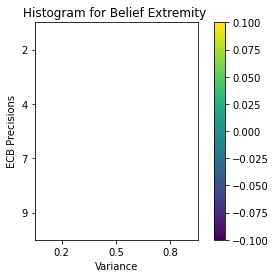

In [95]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, connectedness_values, all_parameters, params.avg_belief_extremity, 2, 0)
print(ecb_b_db_clustering_hist)
plot_2d_histogram(ecb_b_db_clustering_hist, "Variance", "ECB Precisions", ecb_precision_gammas, connectedness_values)
plt.title("Histogram for Belief Extremity ")

Parameter configuration that leads to clustering in general


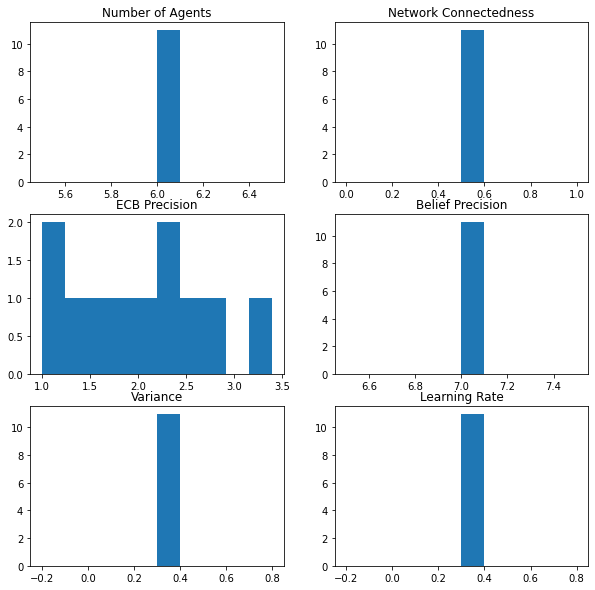

In [200]:
print("Parameter configuration that leads to clustering in general")
plot_param_histograms(clustering_params)

Parameter configuration that leads to clustering in general


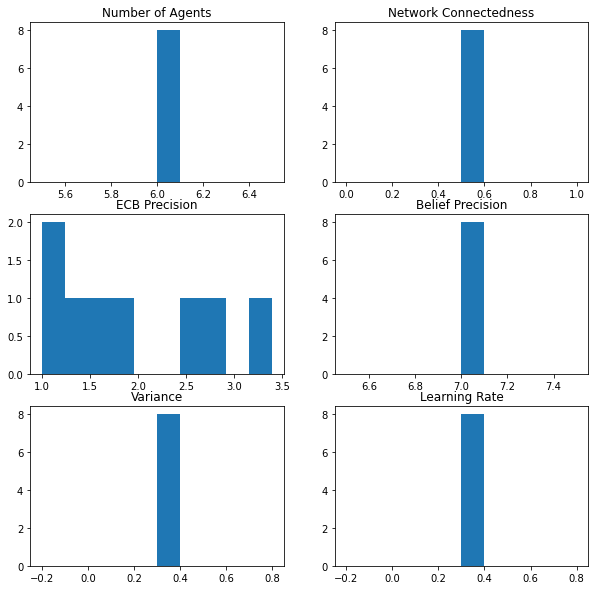

In [201]:
print("Parameter configuration that leads to clustering in general")
plot_param_histograms(clustering_params_db)
#these are the same 

In [202]:
#other interesting measures of clustering is the nonzero KL divergences, and db indices which are not 1 
#np.mean(params.db_indices[non_zero_kls])

In [204]:
print("The number of parameter configurations in which agents are able to form two discrete clusters is " + str(len(clustering_indices)))

The number of parameter configurations in which agents are able to form two discrete clusters is 11


In [205]:
insiders_dominate = np.where(clustering_ratios[:,-1] <= 0.2)[0]
insiders_params = clustering_params[insiders_dominate]
insiders_ratios = clustering_ratios[insiders_dominate]


Parameter configuration that leads to insider sampling dominating


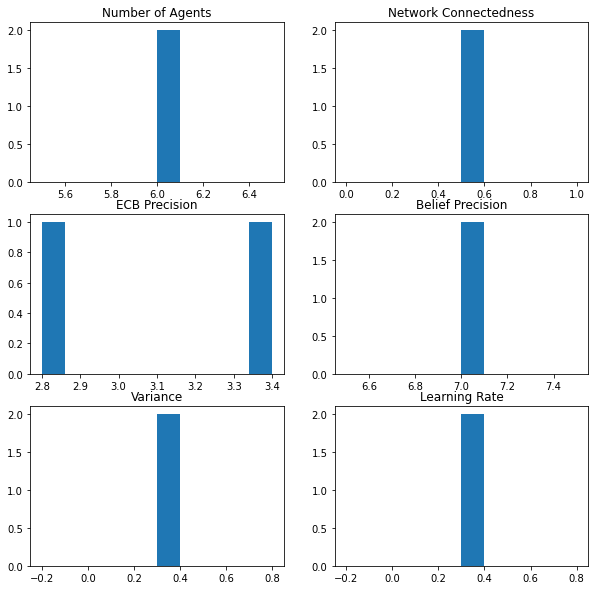

In [206]:
print("Parameter configuration that leads to insider sampling dominating")
plot_param_histograms(insiders_params)

In [ ]:
print("The number of parameter configurations in which agents end up sampling insiders more than outsiders is " + str(len(insiders_dominate)))

In [ ]:
periodic_indices = np.where(np.absolute(clustering_ratios[:,-1] - clustering_ratios[:,0]) < 0.02)[0]
print("The number of configurations that lead to periodic sampling behaviour is " + str(len(periodic_indices)))
periodic_params = clustering_params[periodic_indices]
periodic_ratios = clustering_ratios[periodic_indices]

In [ ]:
print("Parameter configuration that leads to periodic sampling dominating")
plot_param_histograms(periodic_params)

In [ ]:
biggest_insider_skew = np.where(clustering_ratios[:,0] - clustering_ratios[:,-1] > 0.02)[0]
print(len(biggest_insider_skew))
insider_skew_params = clustering_params[biggest_insider_skew]
insider_skew_ratios = clustering_ratios[biggest_insider_skew]

In [ ]:
print("Parameter configuration that leads to insider sampling dominating")
plot_param_histograms(insider_skew_params)

In [ ]:
ecb_learning_ratio_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, clustering_params, clustering_ratios, 2, -1)
print(ecb_learning_ratio_clustering_hist)
plot_2d_histogram(ecb_learning_ratio_clustering_hist, "Learning Rate", "ECB Precision Gammas", ecb_precision_gammas, lr)
plt.title("Histogram for insider outsider sampling ratio on configurations that tend to cluster")

High learning rate combined with high epistemic confirmation bias lends to the most insider sampling.

In [ ]:
ecb_learning_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, lr, clustering_params, params.db_indices[clustering_indices], 2, -1)
print(ecb_learning_db_clustering_hist)
plot_2d_histogram(ecb_learning_db_clustering_hist, "Policy Learning Rate", "ECB Precision Gammas", ecb_precision_gammas, lr)
plt.title("Histogram for DB index on configurations that tend to cluster")

Again, high ECB and high learning rate leads to the lowest DB index. 

In [ ]:
ecb_variance_clustering_hist = get_2d_histogram(ecb_precision_gammas, variances, clustering_params, clustering_ratios, 2, -2)
print(ecb_variance_clustering_hist)
plot_2d_histogram(ecb_variance_clustering_hist, "Variance", "ECB Precision Gammas", ecb_precision_gammas, variances)
plt.title("Histogram for insider outsider sampling ratio on configurations that tend to cluster")

Here it seems that when ECB is low, having a low variance will lead to the sampling of more insiders than when variance is high, which suggests that the variance lends to some asymmetry in the sampling due to having preferences over a particular agent or a particular idea. 

In [ ]:
ecb_b_clustering_hist = get_2d_histogram(ecb_precision_gammas, b_precision_gammas, clustering_params, clustering_ratios, 2, 3)
print(ecb_b_clustering_hist)
plot_2d_histogram(ecb_b_clustering_hist, "Belief Determinism", "ECB Precision Gammas", ecb_precision_gammas, b_precision_gammas)
plt.title("Histogram for insider outsider sampling ratio on configurations that tend to cluster")

In [ ]:
ecb_b_clustering_hist = get_2d_histogram(ecb_precision_gammas, b_precision_gammas, insiders_params, insiders_ratios, 2, 3)
print(ecb_b_clustering_hist)
plot_2d_histogram(ecb_b_clustering_hist, "Belief Determinism", "ECB Precision Gammas", ecb_precision_gammas, b_precision_gammas)
plt.title("Histogram for insider outsider sampling ratio on configurations that tend to cluster")

When ECB is low, high belief determinism will actually lead to more outsider dominance.

In [ ]:
ecb_b_db_clustering_hist = get_2d_histogram(ecb_precision_gammas, b_precision_gammas, clustering_params, params.db_indices[clustering_indices], 2, 3)
print(ecb_b_db_clustering_hist)
plot_2d_histogram(ecb_b_db_clustering_hist, "Belief Determinism", "ECB Precision Gammas", ecb_precision_gammas, b_precision_gammas)
plt.title("Histogram for DB index on configurations that tend to cluster")

In [ ]:
ecb_b_db_clustering_hist = get_2d_histogram(lr, b_precision_gammas, clustering_params, params.db_indices[clustering_indices], -1, 3)
print(ecb_b_db_clustering_hist)
plot_2d_histogram(ecb_b_db_clustering_hist, "Belief Determinism", "Learning Rates", lr, b_precision_gammas)
plt.title("Histogram for DB index on configurations that tend to cluster")

In [ ]:
#I want to take the outsider sampling frequency and plot a histogram across belief precision and learning rate for the clustering data 
def get_2d_histogram(param1, param2, conditional_parameters, conditional_metric, param1_index, param2_index):
    hist = np.zeros((len(param1), len(param2)))
    for i, e in enumerate(param1):
        indices = np.where(conditional_parameters[:,param1_index] == e)[0]
        _params = conditional_parameters[indices]
        metrics = conditional_metric[indices]
        for j, l in enumerate(param2):
            p2_indices = np.where(_params[:,param2_index]==l)[0]
            p2_params = _params[p2_indices]
            p2_metrics = metrics[p2_indices]
            avg_metric = np.nanmean(p2_metrics[np.isfinite(p2_metrics)])
            hist[i,j] = avg_metric
    return hist

def plot_2d_histogram(hist, x_label, y_label, param1, param2):

    plt.imshow(hist)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.set_xticks(np.arange(0,len(param2),1))
    ax.set_yticks(np.arange(0,len(param1),1))
    ax.set_xticklabels(param2)
    ax.set_yticklabels(param1)
    plt.colorbar()
    #    list_of_outsider_metrics = np.where(clustering_ratios

In [ ]:
#The idea is that there is some parameter value that creates a change in the agents' behaviour. 
#after crossing some threshold, agents will begin to converge to an attracting set 
#the attracting set is their cluster - or it is the point of no return, once they only sample insiders 


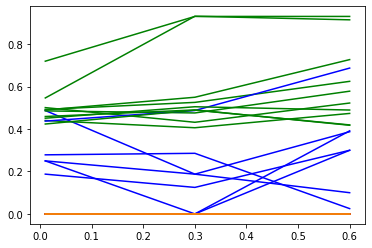

In [54]:
#bifurcation diagrams are usually talked about in terms of some differential equation or like the logistic funciton so i guess we could do like 
def get_all_values(param1, param2, conditional_parameters, conditional_metric, param1_index, param2_index):
    hist = np.zeros((len(param1), len(param2)),dtype = object)
    for i, e in enumerate(param1):
        indices = np.where(conditional_parameters[:,param1_index] == e)[0]
        _params = conditional_parameters[indices]
        metrics = conditional_metric[indices]
        for j, l in enumerate(param2):
            p2_indices = np.where(_params[:,param2_index]==l)[0]
            p2_params = _params[p2_indices]
            p2_metrics = metrics[p2_indices]
            all_metrics = p2_metrics[np.isfinite(p2_metrics)]
            hist[i,j] = all_metrics
    return hist
def my_function(ecb, l_r, i):
    all_m = get_all_values(ecb_precision_gammas, lr, all_parameters, params.db_indices, 2, -1)
    return all_m

fig, ax = plt.subplots(1,1)
all_m = np.array(get_all_values(ecb_precision_gammas, lr, all_parameters, params.insider_outsider_ratios[:,-1], 2, -1))
colors = ['green', 'blue', 'red','orange']
for k in range(10):
    for i in range(4):
        values = []
        for j in range(3):
            values.append(all_m[i,j][k])
        plt.plot(lr, values, c = colors[i])
        #plt.show()


        
  

In [ ]:
all_m = np.array(get_all_values(ecb_precision_gammas, lr, all_parameters, params.insider_outsider_ratios[:,-1], 2, -1))

for k in range(10):
    for i in range(4):
        values = []
        for j in range(3):
            values.append(all_m[i,j][k])
        plt.plot(lr, values, c = colors[i])
        #plt.show()


In [ ]:

fig, ax = plt.subplots(1,1)
all_m = np.array(get_all_values(ecb_precision_gammas, lr, all_parameters, params.insider_outsider_ratios[:,-1], 2, -1))
for k in range(100):
    try:
        for i in range(4):
            values = []
            for j in range(3):
                values.append(all_m[i,j][k])
            plt.plot(lr, values)
    except:
        continue

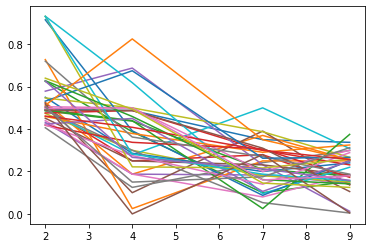

In [102]:
for k in range(100):
    try:
        for i in range(3):
            values = []
            for j in range(4):
                values.append(all_m[j,i][k])
            plt.plot(ecb_precision_gammas, values)
    except:
        continue

In [28]:
%config InlineBackend.figure_format = 'svg'


In [217]:
def similarity_matrix(belief_hist):
    T = belief_hist.shape[0]

    KLD_intra_beliefs = get_KLDs(belief_hist)
    believers = np.where(belief_hist[-1,0,:] > 0.5)
    nonbelievers = np.where(belief_hist[-1,0,:] < 0.5)
    cluster_sorted_indices = [i for i in believers[0]]
    for j in nonbelievers[0]:
        cluster_sorted_indices.append(j)

    
    color_map = plt.cm.get_cmap('gray').reversed()


    single_slice = KLD_intra_beliefs[:,:,-1]
    sorted_slice = single_slice[cluster_sorted_indices,:][:,cluster_sorted_indices]
    plt.imshow(sorted_slice, cmap = color_map)
    plt.title("Belief similarity matrix")
    plt.show()
    plt.clf()

In [224]:

#num agents, connectedness, ecb precision, env precision, b precision, lr, variance 
optimal_params = clustering_params[-1]
params.update_params(optimal_params)
params.get_all_sim_results_from_parameters()
beliefs = params.all_qs

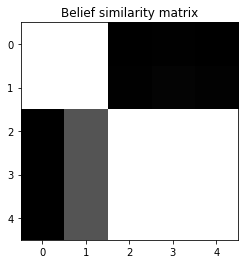

<Figure size 432x288 with 0 Axes>

In [225]:
kld_matrices = similarity_matrix(beliefs[2])

In [24]:
def get_agent_data(agent, result, cluster1, cluster2):
    agent_adj_mat = result['adj_mat'][:,agent,:]
    agent_beliefs = result['all_qs'][:,:,:,agent]
    agent_samplings = result['all_neighbour_sampling'][:,:,agent]
    agent_tweets = result['all_tweets'][:,:,agent]
    agent_cluster = cluster1[0] if agent in cluster1[0] else cluster2[0]
    other_cluster = cluster1[0] if agent not in cluster1[0] else cluster2[0]
    neighbours = list(is_connected(agent_adj_mat[0])[0])
    outsider_neighbours = np.intersect1d(neighbours, other_cluster)
    insider_neighbours = np.intersect1d(neighbours, agent_cluster)
    
    agent_data = (agent_adj_mat, agent_beliefs, agent_samplings, agent_tweets, agent_cluster, other_cluster, neighbours, outsider_neighbours, insider_neighbours)
    return agent_data

def find_one_agent_two_neighbours_opposite_cluster(parameters, condition = True, trial = None, agent = None):
    params.update_params(parameters)
    beliefs = params.all_qs
    result = params.get_all_sim_results_from_parameters()
    if condition == True:
        for trial in range(30):
                #what are the clusters? 
            all_beliefs_t = beliefs[trial]
            cluster1 = np.where(all_beliefs_t[-1,1,:] > 0.5)
            cluster2 = np.where(all_beliefs_t[-1,1,:] < 0.5)
            for agent in range(parameters[0]):
                agent_data = get_agent_data(agent,result, cluster1, cluster2)
                if len(agent_data[-3]) == 2 and len(agent_data[-2]) == 1 and len(agent_data[-1]) == 1:
                    print("Found condition!")
                    print(cluster1)
                    print(cluster2)
                    return result, trial, agent, cluster1, cluster2, agent_data
    else:
        all_beliefs_t = beliefs[trial,:,:,:] 
        cluster1 = np.where(all_beliefs_t[-1,1,:] > 0.5)
        cluster2 = np.where(all_beliefs_t[-1,1,:] < 0.5)
        agent_data = get_agent_data(agent,result, cluster1, cluster2)
                    
        return result, trial, agent, cluster1, cluster2, agent_data
            

In [25]:
def is_connected(adj_mat):
    return np.where(adj_mat == 1)

In [426]:
test_params = all_params[1]
params.update_params(test_params)
beliefs = params.all_qs


In [344]:
result, trial, agent, cluster1, cluster2, agent_data = find_one_agent_two_neighbours_opposite_cluster(test_params)

Found condition!
(array([0, 3, 4]),)
(array([1, 2]),)


In [439]:
result, trial, agent, cluster1, cluster2, agent_data = find_one_agent_two_neighbours_opposite_cluster(test_params, False, 4, 0)

In [440]:
trial

4

In [441]:
(agent_adj_mat, agent_beliefs, agent_samplings, agent_tweets, agent_cluster, other_cluster, neighbours, outsider_neighbours, insider_neighbours) = agent_data

In [442]:
agent_samplings[trial]

array([1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1.,
       1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2.,
       1., 1., 2., 1., 1., 2., 1., 1., 2., 1.])

In [443]:
outsider_indices = [np.where(agent_samplings[trial] == i) for i in outsider_neighbours]
insider_indices = [np.where(agent_samplings[trial] == i) for i in insider_neighbours]

In [444]:
insider_indices

[(array([ 0,  1,  3,  4,  6,  7,  9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21,
         22, 24, 25, 27, 28, 30, 31, 33, 34, 36, 37, 39, 40, 42, 43, 45, 46,
         48, 49, 51, 52, 54, 55, 57, 58, 60]),)]

In [55]:
def sampling_data(all_sampling_data, idx, parameters, all_qs, adj_mat, all_samplings):
    all_sampling_data[idx] = {}
    for trial in range(30):
        #print()
        #print("trial: "  + str(trial))
            #what are the clusters? 
        cluster1 = np.where(all_qs[trial][-1,1,:] > 0.5)
        cluster2 = np.where(all_qs[trial][-1,1,:] < 0.5)
        if len(cluster1[0]) > 0 and len(cluster2[0]) > 0:
            all_sampling_data[idx][trial] = {}

            for agent in range(parameters[0]):
                #print("Agent: " + str(agent))
                agent_cluster = cluster1[0] if agent in cluster1[0] else cluster2[0]
                other_cluster = cluster1[0] if agent not in cluster1[0] else cluster2[0]
                try:
                    neighbours = list(np.where(adj_mat[:,agent,:][0] ==1)[0])
                except:
                    print(agent)
                    print(adj_mat.shape)
                    print(p)
                outsider_neighbours = np.intersect1d(neighbours, other_cluster)
                insider_neighbours = np.intersect1d(neighbours, agent_cluster)
                if len(outsider_neighbours) > 0 and len(insider_neighbours) > 0:
                    agent_samplings = all_samplings[:,:,agent][trial]
                    outsider_indices = [np.where(agent_samplings == i) for i in outsider_neighbours]
                    insider_indices = [np.where(agent_samplings == i) for i in insider_neighbours]
                    all_sampling_data[idx][trial][agent] = {}
                    for j in range(len(outsider_indices)):
                        #outsider_freq = [outsider_indices[j][0][i+1]-outsider_indices[j][0][i] for i in range(len(outsider_indices[j][0])-1)]
                        #print("outsider frequency: " + str(outsider_freq))
                        all_sampling_data[idx][trial][agent]["outsider_indices"] = []
                        all_sampling_data[idx][trial][agent]["outsider_indices"].append(outsider_indices[j][0])
                        all_sampling_data[idx][trial][agent]["outsider_neighbours"] = outsider_neighbours

                    for k in range(len(insider_indices)):
                        #insider_freq = [insider_indices[k][0][i+1]-insider_indices[k][0][i] for i in range(len(insider_indices[k][0])-1)]
                        #print("insider frequency: " + str(insider_freq))
                        all_sampling_data[idx][trial][agent]["insider_indices"] = []
                        all_sampling_data[idx][trial][agent]["insider_indices"].append(insider_indices[k][0])
                        all_sampling_data[idx][trial][agent]["insider_neighbours"] = insider_neighbours

    return all_sampling_data

        

In [501]:
params

In [27]:
all_params = list(params.get_param_combinations())
all_sampling_data = {}
for idx, p in enumerate(all_params):
    params.update_params(p)
    params.get_all_sim_results_from_parameters()
    all_sampling_data = sampling_data(all_sampling_data, idx, p, params.all_qs, params.adj_mat, params.all_neighbour_samplings)


In [22]:
x = all_params.index(tuple(optimal_params))

In [23]:
x

30

In [34]:
outsider_indices = all_sampling_data[x][10][2]["outsider_indices"]
insider_indices = all_sampling_data[x][10][2]["insider_indices"]
outsider_neighbours = all_sampling_data[x][10][2]["outsider_neighbours"]
insider_neighbours = all_sampling_data[x][10][2]["insider_neighbours"]


In [68]:
#plt.plot(range(61), agent_samplings[trial])
def plot_samples(outsider_indices, insider_indices, outsider_neighbours, insider_neighbours):
    if len(outsider_indices) > 0:
        for j in range(len(outsider_indices)):
            plt.scatter(outsider_indices[j], np.tile(0, len(outsider_indices[j])), color = 'green', label = "outsider")
    for i in range(len(insider_indices)):
        plt.scatter(insider_indices[i], np.tile(1, len(insider_indices[i])), color = 'orange', label = "insider")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Agent Sampling")
    plt.title("Sampling Behaviour")

In [328]:
agent_reads = [result['all_tweets'][trial,t,int(a)] for t,a in enumerate(agent_samplings[trial,:])]

In [ ]:
#average number of outsider samplings per agent at the final 20 timesteps 
#average over agents and trial 
#2d heat map of the ratios over beleif precision / learning rate / ecb precision 


#for just ecb precision could just have curves over time and y being the frequency sampling ratio 

#tensor of parameters (ecb, belief, learning rate) and then each entry is the average for fixed parameter respectively
#plt.imshow on a slice of that cube 


In [335]:
behaviour = [( agent_tweets[trial][t], agent_reads[t], agent_beliefs[trial,:,0][t], (agent_beliefs[trial,:,0][t] - agent_beliefs[trial,:,0][t-1] )) for t in range(1,len(agent_reads)-1)]

So two general behaviours are possible: Either an agent will form a conclusion by choosing to more frequently sample within one cluster group than the other, or they will continue to sample from both cluster groups and remain centrist. In both cases, agents will choose their own leaning - only to tweet one hashtag over the other, but will continue to sample both leanings, to varying frequencies based on their beliefs.  

Text(0.5, 1.0, 'Effect of Belief Precision on Sampling Frequency')

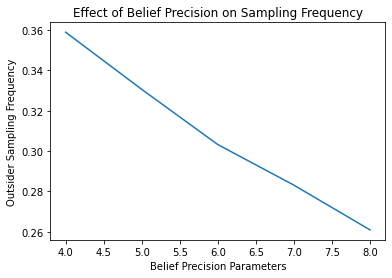

In [113]:
plt.plot(b_precision_gammas[1:], sampling_data[1:])
plt.xlabel("Belief Precision Parameters")
plt.ylabel("Outsider Sampling Frequency")
plt.title("Effect of Belief Precision on Sampling Frequency")